# Import packages

In [20]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics  import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from CV_utils import CV_regressor
from plot_utils import *
from RegressionModels import ClusterElasticNet, GroupLasso

from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Open preprocessed phenotype and kinase specificity matrix

In [2]:
path = './data/'

In [3]:
### import drugs' charachteristics such as dose, label, name

drug_phenotype_df = pd.read_csv(path + 'drug_phenotype_data.csv') 
drug_doses  = drug_phenotype_df['dose (uM)']
drug_labels = drug_phenotype_df['dose (label)']
drug_names = drug_phenotype_df['drugShortNames']

In [4]:
kinase_df = pd.read_csv(path + 'kinase_data.csv')
phenotype = pd.read_csv(path + 'y_plateau_preprocessed.csv')

drug_info_df = pd.read_csv(path + 'drug_phenotype_data.csv')

In [5]:
### mask with good doses
not_specific_drugs = ["C4", "F6"]
final_mask = pd.read_csv(path + 'good_doses_mask.csv')['if_used_in_final'].values & \
             drug_names.apply(lambda x: x not in not_specific_drugs)


# additionally throw out all plateau points except for the last one (highest dose when phenotype=0.7) 
#for each drug.

# final_mask = pd.read_csv("final_mask_1_point_on_plateau.csv")['if_used_in_final'].values


###check
assert len(kinase_df) == len(phenotype) == len(final_mask)

X = kinase_df[final_mask]

X_scaled = pd.DataFrame(StandardScaler(with_mean=True).fit_transform(X), columns=X.columns, index=X.index)

y = phenotype['Y'][final_mask]

y_drug_names = drug_names[final_mask]
y_drug_doses = drug_doses[final_mask]

print(f'After preprocessing we are left with {y_drug_names.nunique()} drugs, {final_mask.sum()} overall doses.')

After preprocessing we are left with 45 drugs, 318 overall doses.


# Check linear relationship for each kinase

In [22]:
from plot_utils import plot_each_col_X_vs_y

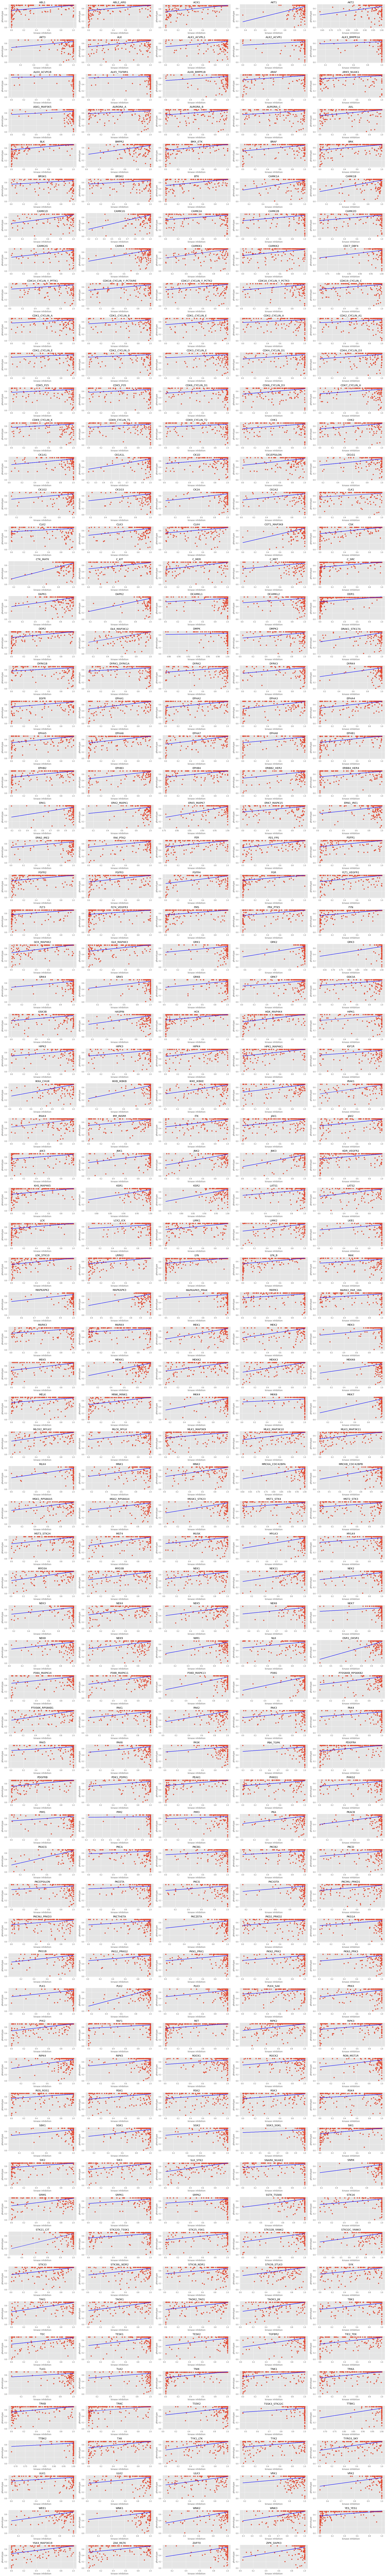

In [23]:
%matplotlib inline
plot_each_col_X_vs_y(X, y, num_cols=5, figsize=(30,200))

# Linear Regression fitting with LODOCV 

To evaluate the perfomance of our model we use LODOCV (Leave-One-Drug-Out-Cross-Validation). Sequentially we throw out each drug in all its doses from the dataset, train our model on the remaining drugs, and test the model performance on the deleted drug. On each iteration we note correlation between predicted and true phenotypes and finally take the average of these results. The obtained number defines the quality of a given model. We avoid using standard Leave-One-Out-Cross-Validataion (LOOCV) because of high correlation between kinase specificities corresponding to the doses of one drug. Due to this fact, predicting a phenotype for one dose of a drug while having another dose in a training sample turned out to be an easy task for a model making the LOOCV a non-instructive metric for our problem.

In [12]:
# pca = PCA(318)
# pca.fit(X)
# %matplotlib inline
# plt.plot(np.cumsum(pca.explained_variance_ratio_))

# X_pca = pd.DataFrame(PCA(40).fit_transform(X), index=X.index)

In [26]:
# regularization parameter alpha should be tuned, l1_ratio is less importnat though also can be tuned

sample_weight = y.apply(lambda x: np.exp(-(x - 0.35) ** 2))

net = ElasticNet(alpha=0.01, l1_ratio=0.5)
res_dict, y_pred, kinase_2_importance = CV_regressor(net, X_scaled, y, y_drug_names, sample_weight=None, 
                                                     metric=mean_absolute_error)

print(res_dict)

{'r2': 0.515, 'cor': 0.718, 'train': 0.036, 'test': 0.057}


# Visualization

In [30]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values

%pylab
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [92]:
### see the dict of importances
kinase_2_importance 

[('PLK2', 0.024640781360747082),
 ('TAK1', 0.023481406438466218),
 ('ERK5_MAPK7', 0.020219783241212534),
 ('MST4', 0.018982875831209892),
 ('MEK2', 0.017786629358519254),
 ('EPHA3', 0.015574423065125359),
 ('MAPKAPK5_PRAK', 0.01059289540365811),
 ('JNK2', 0.009121868530697429),
 ('CTK_MATK', 0.008576584827872972),
 ('YES_YES1', 0.008350212979630423),
 ('P38G', 0.008129082731156588),
 ('TLK2', 0.006931797504966291),
 ('P70S6K_RPS6KB1', 0.0068850945652187915),
 ('TLK1', 0.005828853523513264),
 ('IKKE_IKBKE', 0.004594708307411666),
 ('STK21_CIT', 0.0045511467822193855),
 ('MINK_MINK1', 0.003841165917155857),
 ('ITK', 0.003294571552585158),
 ('IR', 0.002992667844115976),
 ('WNK2', 0.002886411449657628),
 ('DAPK2', 0.0027593236629843243),
 ('PKACG', 0.0026659872348800107),
 ('PIM2', 0.0026449592433452655),
 ('ALK3_BMPR1A', 0.002463359035378632),
 ('MARK4', 0.00219091940442729),
 ('CAMK2G', 0.0021862419013586537),
 ('AURORA_A', 0.0020021859250682504),
 ('MLCK2_MYLK2', 0.002000399664988316),


In [29]:
## The same function can be used to visualize kinase inhibition vs phenotype
## You can click on each point and see what dose and drug in corresponds to

y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(X["FYN"], y, y_points_names, y_drug_names, if_plot_diag_line=False, lims=(-0.1, 1.1))

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [248]:
### List of 6 kinases which were proved to be responsible for the phenotype is highly correlated, so 
### we do not expect all of them to appear in the list of important kinases.

# interesting_kinases = ["FYN", "LYN", "EPHB2", "MINK_MINK1", "YES_YES1", "LATS2"]
# kinase_df[interesting_kinases].corr()

# Separate kinases into groups

## 0. KMeans

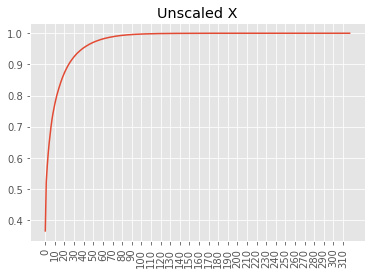

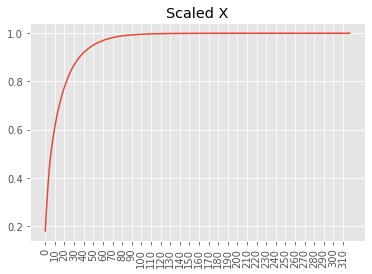

In [25]:
pca = PCA(min(X.shape))
pca.fit_transform(X.T)

%matplotlib inline
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Unscaled X")
# plt.hlines(0.9, 0, min(X.shape), linestyles="dashed", color="blue")
plt.xticks(range(0, min(X.shape), 10), rotation=90)
plt.show()

pca = PCA(25)
X_drug_feat_pca = pd.DataFrame(pca.fit_transform(X.T))

%matplotlib inline
pca = PCA(min(X_scaled.shape))
pca.fit_transform(X_scaled.T)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Scaled X")
# plt.hlines(0.9, 0, min(X.shape), linestyles="dashed", color="blue")
plt.xticks(range(0, min(X_scaled.shape), 10), rotation=90)
plt.show()

pca = PCA(40)
X_scaled_drug_feat_pca = pd.DataFrame(pca.fit_transform(X_scaled.T))

In [549]:
cluster_range = range(2, 200)
inertias = []
for n_clusters in tqdm(cluster_range):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X_drug_feat_pca)
    inertias.append(kmeans.inertia_)
    

100%|█████████████████████████████████████████| 198/198 [00:37<00:00,  5.32it/s]


(369, 25)


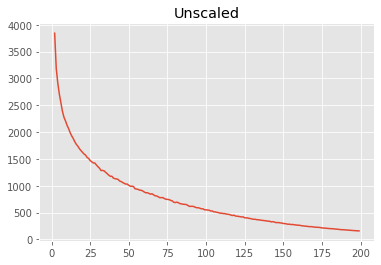

In [551]:
print(X_drug_feat_pca.shape)
%matplotlib inline
plt.plot(cluster_range, inertias)
plt.title("Unscaled")
plt.show()

### Scaled showed siilar results

## 1. Cluster Elastic Net (CEN)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4011669/

In [6]:
model_kwargs = {"n_clusters": 25, "lambda1": 1e-3, "lambda2": 1e-3, 
              "max_iter": 30, "tol": 1e-3, 
               "weight_update": "full"}

CEN = ClusterElasticNet(**model_kwargs)

In [11]:
CEN.fit(X,y, verbose=False)

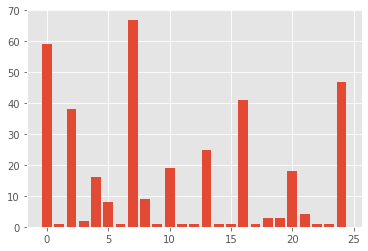

In [10]:
%matplotlib inline
cluster_counter = Counter(CEN.labels_)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [63]:
cluster_2_max_weight = print_cluster_report(CEN, CEN.labels_)

0
Num elems in cluster 2
Max abs weight 0.0466
{'MEK1': 0.0292, 'MEK2': 0.0466}

1
Num elems in cluster 210
Max abs weight 0.0296
{'AKT3': 0.001, 'ALK1_ACVRL1': 0.0003, 'ALK5_TGFBR1': 0.0, 'ARAF': 0.0033, 'ARK5_NUAK1': 0.0038, 'AURORA_C': 0.0077, 'C_MET': 0.0097, 'CAMK1A': 0.0013, 'CAMK1B': 0.0051, 'CAMK1D': 0.0091, 'CAMK2A': 0.0065, 'CAMK2B': 0.0089, 'CAMK2D': 0.0013, 'CAMKK1': 0.011, 'CDK1_CYCLIN_A': 0.0088, 'CDK1_CYCLIN_B': 0.0104, 'CDK14_CYCLIN_Y_PFTK1': 0.0102, 'CDK16_CYCLIN_Y_PCTAIRE': 0.014, 'CDK2_CYCLIN_A1': 0.0018, 'CDK2_CYCLIN_O': 0.0006, 'CDK4_CYCLIN_D3': 0.009, 'CDK5_P35': 0.0075, 'CK1A1': 0.0102, 'CK1A1L': 0.002, 'CK1D': 0.0142, 'CK1EPSILON': 0.001, 'CK1G3': 0.0004, 'CK2A2': 0.0104, 'CLK1': 0.007, 'COT1_MAP3K8': 0.0061, 'CTK_MATK': 0.002, 'DAPK1': 0.0058, 'DAPK2': 0.0017, 'DLK_MAP3K12': 0.0038, 'DMPK2': 0.0099, 'DYRK2': 0.0055, 'DYRK3': 0.0073, 'DYRK4': 0.0032, 'EGFR': 0.003, 'EPHA6': 0.0077, 'ERBB2_HER2': 0.0111, 'ERBB4_HER4': 0.0066, 'ERK2_MAPK1': 0.0023, 'ERK5_MAPK7': 0

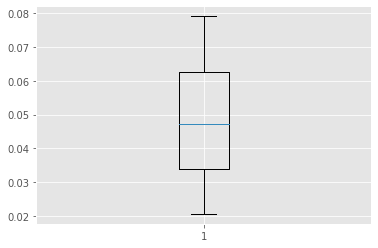

In [64]:
%matplotlib inline
plt.boxplot(cluster_2_max_weight.values())
plt.show()

In [51]:
res_dict, y_pred, kinase_2_importance = CV_regressor(CEN, X, y, y_drug_names, 
                                                     fit_kwargs={"verbose": False})

KeyboardInterrupt: 

In [52]:
print(res_dict)

{'r2': 0.358, 'cor': 0.642, 'train': 0.025, 'test': 0.065}


In [53]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## 2. Group Lasso with Pre-clustering

In [13]:
class GroupLasso:
    def __init__(self, group_index, alpha=0.5, lambda1=1e-3):
        self.group_index = np.array(group_index)
        self.alpha = alpha
        self.lambda1 = lambda1
        
    def fit(self, X, y):
        assert X.shape[1] == len(self.group_index), "wrong number of variables"
        
        X_array = np.array(X)
        y_array = np.array(y, dtype=float)
        
        w = cp.Variable(X_array.shape[1])
        b = cp.Variable(1)
        
        group_2_num_elems = Counter(self.group_index)
        
        group_coef = list(map(lambda g: np.sqrt(group_2_num_elems[g]), self.group_index))
        regularizer = self.lambda1 * (self.alpha * cp.norm(w, 1) + \
                                (1 - self.alpha) * cp.scalar_product(group_coef, cp.square(w)))

        sum_squares = cp.sum_squares(b + w @ X_array.T - y_array)
        objective = cp.Minimize(sum_squares / (2 * len(y_array)) + regularizer) 
        prob = cp.Problem(objective)
        _ = prob.solve()
        self.coef_ =  w.value
        self.intercept_ = b.value
        
    def predict(self, X):
        return X @ self.coef_ + self.intercept_

### Family clustering using Kinome tree

In [14]:
families_df = pd.read_excel("KIR3KinaseCategories.xlsx")["Category"]
families_2_index = {family: index + 1 for index, family in enumerate(families_df.unique())}
index_2_family = {index: family for family, index in families_2_index.items()}
families_indices = families_df.apply(lambda x: families_2_index[x])

FileNotFoundError: [Errno 2] No such file or directory: 'KIR3KinaseCategories.xlsx'

In [106]:
lasso_kwargs={"group_index": families_indices, "alpha": 0.2, "lambda1": 1e-2}
group_lasso_family = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso_family, X_scaled, y, y_drug_names)
print(res_dict)

{'r2': 0.517, 'cor': 0.721, 'train': 0.029, 'test': 0.057}


In [107]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [108]:
print_cluster_report(group_lasso_family, families_df.values, features=X.columns)

AGC
Num elems in cluster 48
Max abs weight 0.0077
{'ALK1_ACVRL1': 0.0, 'ALK2_ACVR1': 0.0002, 'ALK3_BMPR1A': 0.0028, 'KSR2': 0.0, 'LATS1': 0.0, 'P38A_MAPK14': 0.0, 'P38B_MAPK11': 0.0072, 'PAK5': 0.0, 'PDGFRA': 0.0, 'PEAK1': 0.0, 'PKACB': 0.0, 'PKACG': 0.0, 'STK32C_YANK3': 0.0, 'STK33': 0.0, 'C_SRC': 0.0, 'CAMK1G': 0.0022, 'EPHA2': 0.0, 'EPHA3': 0.0077, 'FYN': 0.0, 'GRK2': 0.0, 'GRK3': 0.0, 'GRK5': 0.0, 'GRK6': 0.0, 'GSK3A': 0.0, 'HASPIN': 0.0049, 'HGK_MAP4K4': 0.0018, 'HIPK3': 0.0, 'IGF1R': 0.0, 'IKKB_IKBKB': 0.0076, 'IRAK4': 0.0, 'IRR_INSRR': 0.0, 'KHS_MAP4K5': 0.0, 'LATS2': 0.0, 'LKB1': 0.0, 'LOK_STK10': 0.0, 'LRRK2': 0.0, 'LYN': 0.0, 'MARK2_PAR_1BA': 0.0, 'MST1_STK4': 0.0, 'MST3_STK24': 0.0, 'P70S6KB_RPS6KB2': 0.0, 'PAK1': 0.0, 'PAK2': 0.0, 'PIM3': 0.0, 'PKCB2': 0.0, 'PKCD': 0.0, 'PKCETA': 0.0, 'PKCIOTA': 0.0}

Atypical
Num elems in cluster 1
Max abs weight 0.0014
{'FES_FPS': 0.0014}

CAMK
Num elems in cluster 61
Max abs weight 0.0088
{'BLK': 0.0, 'CAMK4': 0.0, 'CAMKK1': 0.0037, 'CDK

{'AGC': 0.0077,
 'Atypical': 0.0014,
 'CAMK': 0.0088,
 'CK1': 0.0028,
 'CMGC': 0.0183,
 'Other': 0.0075,
 'STE': 0.0088,
 'TK': 0.0105,
 'TKL': 0.0092}

### KMeans clustering

In [26]:
kmeans = KMeans(25).fit(X_drug_feat_pca)
kmeans_families = pd.Series(kmeans.labels_)

kmeans = KMeans(30).fit(X_scaled_drug_feat_pca)
kmeans_families_scaled = pd.Series(kmeans.labels_)

In [27]:
lasso_kwargs={"group_index": kmeans_families, "alpha": 0.5, "lambda1": 1e-3}
group_lasso = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso, X, y, y_drug_names)
print(res_dict)

{'r2': 0.448, 'cor': 0.683, 'train': 0.86, 'test': -1.2397942589482642e+29}


In [28]:
lasso_kwargs={"group_index": kmeans_families_scaled, "alpha": 0.5, "lambda1":  1e-2}
group_lasso_scaled = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso_scaled, X_scaled, y, y_drug_names)
print(res_dict)

{'r2': 0.508, 'cor': 0.713, 'train': 0.798, 'test': -8.427923923163706e+28}


In [81]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [29]:
group_lasso.fit(X_scaled, y)

In [31]:
cluster_2_max_weight = print_cluster_report(group_lasso, kmeans_families_scaled, features=X.columns)

0
Num elems in cluster 12
Max abs weight 0.0237
{'KSR2': 0.0, 'MAPKAPK3': 0.0076, 'MAPKAPK5_PRAK': 0.0237, 'MEK3': 0.0056, 'MLK4': 0.001, 'MYLK3': 0.0, 'RIPK5': 0.0, 'SSTK_TSSK6': 0.0, 'TSSK3_STK22C': 0.0098, 'ERN2_IRE2': 0.0, 'MAPKAPK2': 0.0, 'MKK6': 0.0}

1
Num elems in cluster 17
Max abs weight 0.0168
{'FGFR1': 0.0, 'FGFR2': 0.0, 'JAK1': 0.0098, 'JAK2': 0.0, 'JAK3': 0.0, 'LIMK1': 0.0, 'TYK2': 0.0023, 'ULK3': 0.0, 'FGFR3': 0.0168, 'LOK_STK10': 0.0, 'LRRK2': 0.0014, 'NEK1': 0.0008, 'SYK': 0.0, 'TAOK1': 0.0101, 'TAOK2_TAO1': 0.0, 'TAOK3_JIK': 0.0024, 'TNK1': 0.0}

2
Num elems in cluster 18
Max abs weight 0.0117
{'CAMK1A': 0.0, 'CAMK1B': 0.0064, 'CAMK1D': 0.0, 'PAK5': 0.0, 'STK38_NDR1': 0.0, 'ZAP70': 0.0, 'CAMK1G': 0.0, 'CHK2': 0.0, 'LKB1': 0.0, 'PAK1': 0.0, 'PAK2': 0.0, 'PAK3': 0.0, 'PAK4': 0.0, 'PAK6': 0.0, 'PKCMU_PRKD1': 0.0, 'PKCNU_PRKD3': 0.0013, 'PKD2_PRKD2': 0.0117, 'STK38L_NDR2': 0.0}

3
Num elems in cluster 6
Max abs weight 0.0016
{'BTK': 0.0, 'EGFR': 0.0016, 'ERBB2_HER2': 0.00

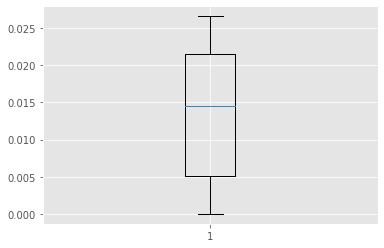

In [32]:
%matplotlib inline
plt.boxplot(cluster_2_max_weight.values())
plt.show()

### Graph clustering

In [12]:
from graph_utils import *

In [13]:
### Make Adjacency Dict
cor_matrix = X.corr()
kinase_2_correlated = make_kinase_2_correlated_neighbor_dict(cor_matrix, 0.9)

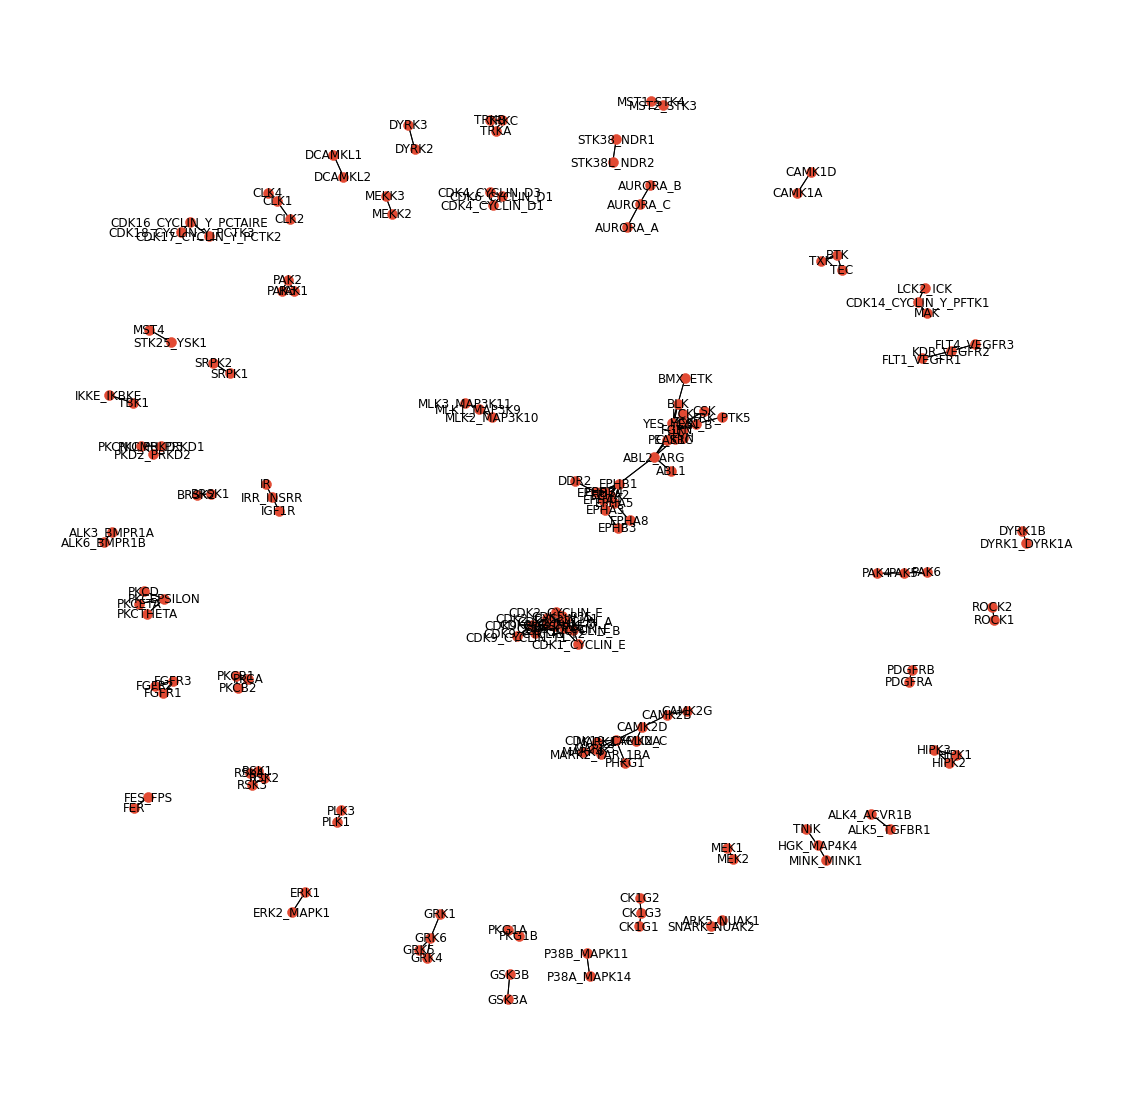

In [14]:
### Draw correlation graph
%matplotlib inline
draw_graph(kinase_2_correlated)

In [15]:
undirected_edges_list = make_undirected_edge_list(kinase_2_correlated)
    
graph = nx.Graph()
graph.add_edges_from(undirected_edges_list)

In [16]:
connected_components = list(nx.connected_components(graph))
print(f"Overall {len(connected_components)} connected components found in correlation graph")

Overall 47 connected components found in correlation graph


In [17]:
kinase_2_component = {}
for i, component in enumerate(connected_components):
    for kinase in component:
        kinase_2_component[kinase] = i + 1
                            
cur_group = len(connected_components)
for kinase in X.columns:
    if kinase not in kinase_2_component.keys():
        kinase_2_component[kinase] = cur_group
        cur_group += 1

In [18]:
group_index = pd.Series(X.columns).apply(lambda x: kinase_2_component[x])

In [21]:
lasso_kwargs={"group_index": group_index.values, "alpha": 0.5, "lambda1": 0.5 * 1e-3}
group_lasso = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso, X, y, y_drug_names)
print(res_dict)

{'r2': 0.412, 'cor': 0.677, 'train': 0.911, 'test': -1.3015478855169339e+29}


In [66]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [208]:
for cluster in sorted(np.unique(group_index)):
    
    mask = group_index == cluster
    print(f"### {cluster} ###")
    print({k: abs(round(w,4)) for k, w in zip(X.columns[mask], group_lasso.coef_[mask])})
    print()

### 1 ###
{'BLK': 0.009, 'HCK': 0.0, 'LCK': 0.0, 'PEAK1': 0.0, 'ABL1': 0.0033, 'ABL2_ARG': 0.0, 'BMX_ETK': 0.0, 'C_SRC': 0.0, 'CSK': 0.0, 'DDR2': 0.0, 'EPHA2': 0.0, 'EPHA3': 0.0285, 'EPHA4': 0.0163, 'EPHA5': 0.0, 'EPHA8': 0.0, 'EPHB1': 0.0, 'EPHB2': 0.0, 'EPHB3': 0.0029, 'EPHB4': 0.0, 'FGR': 0.0, 'FRK_PTK5': 0.0, 'FYN': 0.0, 'LYN': 0.0, 'LYN_B': 0.0, 'YES_YES1': 0.0035}

### 2 ###
{'CDK1_CYCLIN_B': 0.0, 'CDK2_CYCLIN_A': 0.0, 'CDK2_CYCLIN_A1': 0.0, 'CDK2_CYCLIN_O': 0.0, 'CDK5_P35': 0.0062, 'CDK1_CYCLIN_E': 0.0, 'CDK2_CYCLIN_E': 0.0, 'CDK3_CYCLIN_E': 0.0, 'CDK5_P25': 0.0, 'CDK9_CYCLIN_K': 0.0, 'CDK9_CYCLIN_T1': 0.0, 'CDK9_CYCLIN_T2': 0.0}

### 3 ###
{'PKCA': 0.0429, 'PKCB1': 0.0, 'PKCB2': 0.0}

### 4 ###
{'CAMK2A': 0.0, 'CAMK2B': 0.0, 'CAMK2D': 0.0036, 'CAMK2G': 0.0412, 'MARK3': 0.0151, 'MARK4': 0.1063, 'CDK19_CYCLIN_C': 0.0, 'MARK1': 0.0, 'MARK2_PAR_1BA': 0.0, 'PHKG1': 0.063}

### 5 ###
{'ALK3_BMPR1A': 0.0, 'ALK6_BMPR1B': 0.0175}

### 6 ###
{'PLK3': 0.0, 'PLK1': 0.0}

### 7 ###
{'CDK14_